# ClimateMARGO.jl tutorial

The following schematic shows the full formulation of the MARGO model, which is described in detail in the accompanying (but not yet peer-reviewed) manuscript, available for free at [EarthArXiv.org/5bgyc](https://eartharxiv.org/5bgyc). No-policy baseline emissions $q(t)$ are prescribed, leading to changing greenhouse gas (CO$_{2e}$) concentrations, radiative forcing, temperatures, and climate damages. Emissions can be decreased by **M**itigation; concentrations can be decreased by carbon dioxide **R**emoval; forcing can be decreased by solar **G**eo-engineering; and the "adapted" temperature that leads to climate damages can be reduced by **A**dapting to the changed climate.
<img src="../../docs/src/MARGO_schematic.png" alt="drawing" width="60%" style="float:left"/>

### Import software

The MARGO model has been implemented and registered as the Julia package `ClimateMARGO.jl`, which can be installed with the command `Pkg.add("ClimateMARGO")`.

If you are running this tutorial via Binder, there is no need to install the package; just import it using the command below.

In [32]:
using Revise

In [34]:
using ClimateMARGO # Julia implementation of the MARGO model
using PyPlot # A basic plotting package

In [36]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Utils

## Model configuration

An instance of MARGO `ClimateModelParameters` requires specifying a `name` and the parameters for three model subcomponents:
1. `Domain`: determines the time period of interest, as well as the timestep and– in the policy response mode– the "present" decision-making year.
2. `Economics`: determines exogenous economic growth, the cliamte damage cost function, and the cost function for each of the four controls, and the discount rate.
3. `Physics`: determines the parameters that govern the aiborn fraction of emissions that remain in the atmosphere, the strength of climate feedbacks, and the rate of ocean heat uptake.

An instance of the MARGO `ClimateModel` is determined by combining the prescribed set of `ClimateModelParameters` with timeseries of the four `Controls`, which will act as the control variables in the optimization framework:
1. **M**itigation of baseline emissions
2. **R**emoval of carbon dioxide from the atmopshere
3. **G**eongineering by solar radiation management, and
4. **A**daptating to the changed climate to reduce the damages of climate change impacts.

Here, we run through the full construction of the model with its "default" parameter values.

In [38]:
name = "default";

#### 1. Setting up the temporal grid
First, we need to set up a time-frame for our experiment. Let's begin our simulation in the year 2020– present day– and consider out to 2200, with a 5-year timestep for computational efficiency.

In [40]:
initial_year = 2020. # [yr]
final_year = 2200. # [yr]
dt = 5. # [yr]
t_arr = t(initial_year, final_year, dt);

While the model allows for shifting the "present" year forward or backward in time to simulate past and future policy decision-making processes, we will only consider the simplest case in which we take the perspective of a policy decision maker in the year 2020, which is also the initial year of our simulation.

In [42]:
present_year = initial_year
dom = Domain(dt, initial_year, initial_year, final_year);

#### 2. Configuring the carbon cycle and energy balance models

CO$_{2e}$ concentrations are given by:
\begin{equation}
c_{M,R}(t) = c_{0} + \int_{t_{0}}^{t} rq(t')(1-M(t')) \text{ d}t' - q_{0} \int_{t_{0}}^{t} R(t')\text{ d}t'.
\end{equation}
where $q(t)$ is a specific timeseries of no-climate-policy baseline emissions (with $q(t_{0}) = q_{0}$), $c_{0}$ is the initial CO$_{2e}$ concentration, and $r$ is the fraction of emitted CO$_{2e}$ that remains in the atmosphere net of short-term uptake by the ocean and biosphere. $M(t')$ and $R(t')$ represent the effects emissions mitigation and carbon dioxide removal, respectively, on CO$_{2e}$ concentrations relative to the baseline; they will be initially set to zero and later determined by solving an optimization problem.

The default no-policy scenario is one of rapid, fossil-fueled growth which leads to an accumulation of $c(t) = 1400$ ppm of CO$_{2e}$ in the atmosphere by 2150, when emissions are assumed to finally reach net-zero.

In [44]:
c0 = 460. # [ppm]
r = 0.5; # [1] fraction of emissions remaining after biosphere and ocean uptake (Solomon 2009)

q0 = 7.5
q0mult = 3.
t_peak = 2100.
t_zero = 2150.
q = ramp_emissions(t_arr, q0, q0mult, t_peak, t_zero);

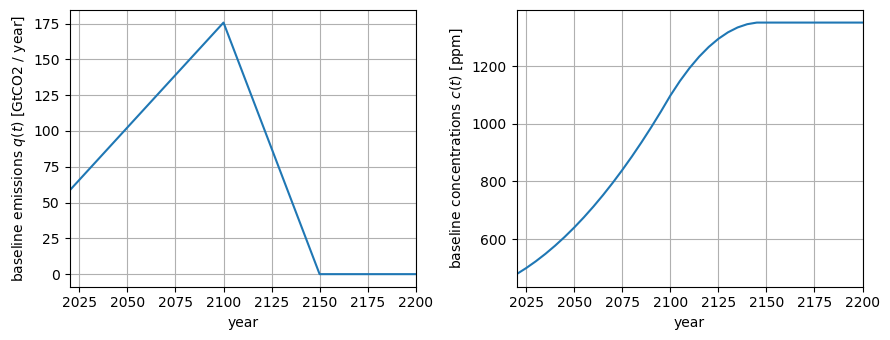

In [46]:
figure(figsize=(9,3.5))

subplot(1,2,1)
plot(t_arr, ppm_to_GtCO2(q))
xlabel("year")
ylabel(L"baseline emissions $q(t)$ [GtCO2 / year]")
xlim([2020, 2200])
grid(true)

subplot(1,2,2)
q_effective = effective_emissions(r, q, 0., 0.) # No mitigation, no carbon removal
c_baseline = c(c0, q_effective, dt)
plot(t_arr, c_baseline)
xlabel("year")
ylabel(L"baseline concentrations $c(t)$ [ppm]")
xlim([2020, 2200])
tight_layout();
grid(true)

These CO$_{2e}$ concentrations drive an anomalous greenhouse effect, which is represented by the radiative forcing
\begin{equation}
F_{M,R,G} = a \ln\left(\frac{c_{M,R}(t)}{c_{0}}\right) - G(t)F_{\infty},
\end{equation}
where $a$ is an empirically determined coefficient, $G(t)$ represents the effects of geoengineering, and $F_{\infty} = 8.5$ W/m$^2$ is a scaling factor for the effects of geoengineering by Solar Radiation Modification (SRM).

In [47]:
a = (6.9/2.)/log(2.); # F4xCO2/2 / log(2) [W m^-2]
Finf = 8.5;

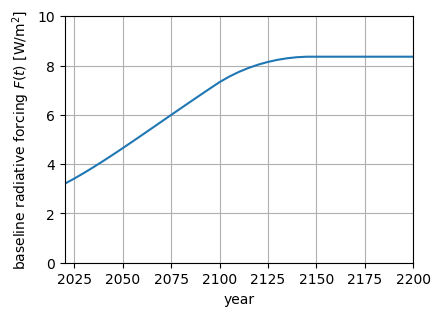

In [48]:
figure(figsize=(4.5,3.2))
F0 = 3.0
F_baseline = F(a, c0, Finf, c_baseline, 0.)
plot(t_arr, F_baseline .+ F0)
xlabel("year")
ylabel(L"baseline radiative forcing $F(t)$ [W/m$^2$]")
xlim([2020, 2200])
grid(true)
ylim([0,10.]);

Next, we configure MARGO's energy balance model, which is forced by the controlled forcing $F_{M,R,G}$. The two-layer energy balance model can be solved, approximately, as:
\begin{equation}
    T_{M,R,G}(t) - T_{0} = \frac{F_{M,R,G}(t)}{B + \kappa} + \frac{\kappa}{B} \int_{t_{0}}^{t} \frac{e^{\frac{t'-t}{\tau_{D}}}}{\tau_{D}} \frac{F_{M,R,G}(t')}{B+\kappa} \, \text{d}t',
\end{equation}
where $T_{0}$ is the initial temperature change relative to preindustrial, $B$ is the feedback parameter, $\kappa$ is , and the timescale $\tau_{D} = \dfrac{C_{D}}{B} \dfrac{B + \kappa}{\kappa}$ is a more convenient expression for the deep ocean heat capacity $C_{D}$.

Default parameter values are taken from [Geoffroy et al. 2013](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-12-00195.1)'s physically-based calibration of the two-layer model to CMIP5.

In [49]:
# Two-layer EBM parameters
B = 1.13; # Feedback parameter [J yr^-1 m^-2 K^-1]
Cd = 106.; # Deep ocean heat capacity [J m^-2 K^-1]
κ = 0.73; # Heat exchange coefficient [J yr^-1 m^2 K^-1]

# Initial condition: present-day temperature, relative to pre-industrial
T0 = 1.1; # [degC] Berkeley Earth Surface Temperature (Rohde 2013)

print("τD = ", Int64(round(τd(Cd, B, κ))), " years")

τD = 239 years

These physical parameters can be used to diagnose the climate sensitivity to a doubling of CO$_{2}$ ($ECS$).

In [50]:
print("ECS = ", round(ECS(a, B),digits=1) ,"ºC")

ECS = 3.1ºC

These parameters define the physical model, which is instantiated by the calling the `Physics` constructor method:

In [51]:
Phys = Physics(c0, T0, a, B, Cd, κ, r);

#### 3. Configuring the simple economic model

Economic growth in MARGO (in terms of Gross World Product, GWP) is exogenous $E(t) = E_{0} (1 + \gamma)^{(t-t_{0})}$ and is entirely determined by the growth rate $\gamma$. By default, we set $\gamma = 2\%$.

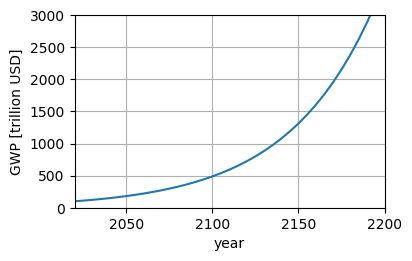

In [52]:
E0 = 100. # Gross World Product at t0 [10^12$ yr^-1]
γ = 0.02 # economic growth rate

figure(figsize=(4, 2.5))
plot(t_arr, E(t_arr, E0, γ))
xlabel("year")
ylabel("GWP [trillion USD]")
xlim([2020, 2200])
ylim([0, 3000]);
grid(true)

Economic damages $D_{M,R,G,A} = \tilde{\beta}E(t) (\Delta T_{M,R,G})^{2} (1 - A(t))$, expressed as a fraction $\tilde{\beta}(\Delta T_{M,R,G})^{2}$ of the instantaneous Gross World Product, increase quadratically with temperature change relative to preindustrial. They can be decrease by adaptation controls $A(t)$. The default value of the damage parameter $\tilde{\beta}$ corresponds to damages of 2\% of GWP at 3ºC of warming.

In [53]:
βtilde = 0.02/(3.0)^2; # damages [%GWP / celsius^2]

The total cost of climate controls is simply the sum of their individual costs, each of which follows a parabolic cost function:
\begin{equation}
    \mathcal{C}_{M,R,G,A} = \mathcal{C}_{M}M^2 + \mathcal{C}_{R}R^2 +  \mathcal{C}_{G}G^2 + \mathcal{C}_{A}A^2
\end{equation}

The calculation of the reference control costs $\mathcal{C}_{M}, \mathcal{C}_{R}, \mathcal{C}_{G}, \mathcal{C}_{A}$ are somewhat more complicated; see our Methods in [the preprint](https://eartharxiv.org/5bgyc/) and `defaults.jl` for details. Here, we simply provide their default numerical values, where the costs of mitigation $\mathcal{C}_{M} = \tilde{\mathcal{C}}_{M} E(t)$ and geoengineering $\mathcal{C}_{G} = \tilde{\mathcal{C}}_{G} E(t)$ grow with the size of the global economy and are thus specified as a fraction of GWP, while adaptaiton and removal costs are in trillions of USD per year.

In [54]:
mitigate_cost = 0.02; # [% GWP]
geoeng_cost = 0.046; # [% GWP]

remove_cost = 13.; # [trillion USD / year]
adapt_cost = 4.5; # [trillion USD / year]

Climate damages and control costs are discounted at the relatively low rate of $\rho = 1\%$, such that future damages and costs are reduced by a multiplicative discount factor $(1 - \rho)^{(t-t_{0})}$.

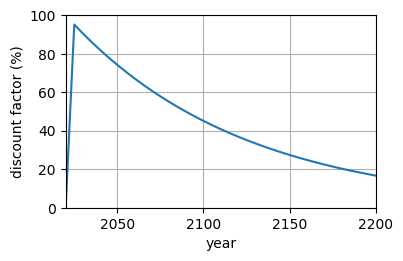

In [55]:
ρ = 0.01;

figure(figsize=(4, 2.5))
plot(t_arr, discount(t_arr, ρ, present_year)*100)
xlabel("year")
ylabel("discount factor (%)")
xlim([2020, 2200])
ylim([0, 100]);
grid(true)

These parameters, in addition to a no-policy baseline emissions time-series and present-day control values, define the economic model.

In [56]:
Econ = Economics(
    E0, γ, βtilde, ρ, Finf,
    mitigate_cost, remove_cost, geoeng_cost, adapt_cost,
    0.1, 0., 0., nothing, # Initial condition on control deployments at t[1]
    q
);

#### A MARGO model configuration is uniquely determined by the parameters defined above

In [57]:
params = ClimateModelParameters(
    name,
    dom,
    Econ,
    Phys
);

## Instanciating the MARGO climate model



Along with economic and physical model components, the timeseries for each of the four controls must be specified. By default, we simply set these to zero.

In [58]:
Cont = Controls(
    zeros(size(t_arr)), # mitigate
    zeros(size(t_arr)), # remove
    zeros(size(t_arr)), # geoeng
    zeros(size(t_arr))  # adapt
);

The above parameters determine the full configuration of the MARGO model, which is instanced using the `ClimateModel` constructor method:

In [59]:
m = ClimateModel(
    params,
    Cont
);

## Model optimization

#### Formulating the optimization problem
By default, the optimization problem we solve is for the most cost-effective combination of controls, as determined by minimization of the discounted net present value,

\begin{equation}
    \min\left\{\int_{t_{0}}^{t_{f}} \mathcal{C}_{M,R,G,A} (1 + \rho)^{-(t-t_{0})} \text{ d}t\right\}
\end{equation}

which keep controlled damages below the level corresponding to a chosen temperature threshold $T^{\star}$,

\begin{equation}
    \tilde{\beta} E(t) (T_{M,R,G})^{2} (1 - A(t)) < \tilde{\beta} E(t) (T^{\star})^{2}.
\end{equation}

In [60]:
temp_goal = 2.0;

#### Additional policy / inertia constraints
The optimization is also subject to the constraints described below.

First, we set a upper bounds on the maximum plausible deployment of each control.

In [61]:
max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>1., "adapt"=>0.4);

Second, we set upper limits on how quickly each control can be ramped up or down.

(Adaptation is treated differently since we it interpret it as buying insurance against future climate damages, although the financing is spread evenly over the entire period.)

In [62]:
max_slope = Dict("mitigate"=>1. /40., "remove"=>1. /40., "geoeng"=>1. /30., "adapt"=>0.);

Third, we impose restrictions on when controls can be first deployed. In particular, since carbon dioxide removal and solar radiation modification do not yet exist at scale, we delay these until 2030 and 2050, respectively, at the earliest.

In [63]:
delay_deployment = Dict(
    "mitigate"=>0.,
    "remove"=>10.,
    "geoeng"=>30.,
    "adapt"=>0.
);

#### Running the optimization

The optimization takes about ~40 seconds the first time it is run as the code compiles, but runs virtually instantly afterwards, even if model parameter values are changed.

In [64]:
using ClimateMARGO.Optimization

In [65]:
@time msolve = optimize_controls!(
    m,
    obj_option = "temp", temp_goal = temp_goal,
    max_deployment = max_deployment, max_slope = max_slope, delay_deployment = delay_deployment
);

Solve_Succeeded
  0.141921 seconds (102.98 k allocations: 4.308 MiB)


In [66]:
isapprox(1, 1.00001, rtol=1.e-5)

true

It is always good to check that the solver actually converged on a valid solution!

## Plotting MARGO results

We provide some convenient functions for plotting basic model results.

In [67]:
using ClimateMARGO.Plotting

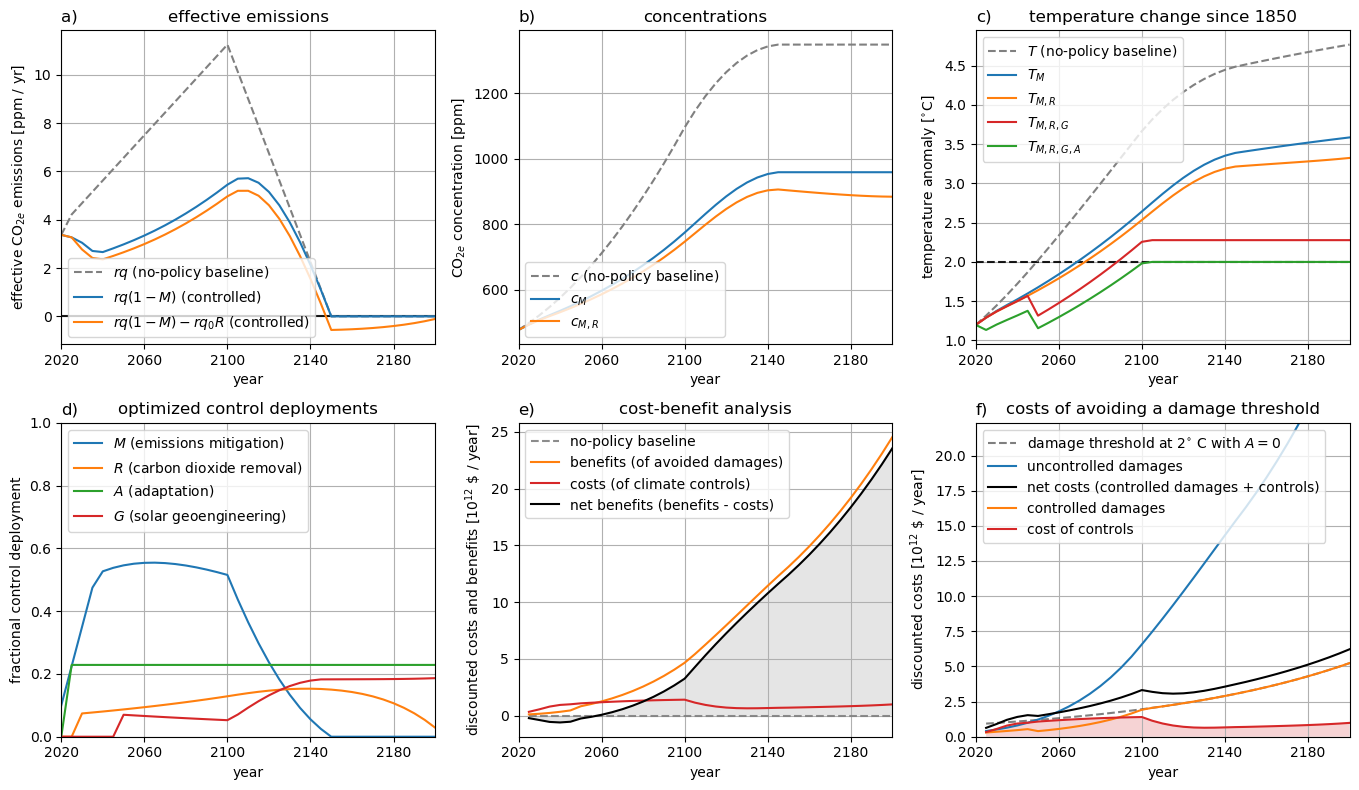

In [68]:
plot_state(m)

## Customizing MARGO

Try changing some of the parameters above and re-running the model!

For example, in the simulation below we set a more stringent temperature goal of $T^{\star} = 1.5$ and omit solar geoengineering and adaptation completely (by setting their maximum deployment to zero).

In [69]:
temp_goal = 1.5
max_deployment["geoeng"] = 0.
max_deployment["adapt"] = 0.

@time optimize_controls!(
    m,
    obj_option = "temp", temp_goal = temp_goal,
    max_deployment = max_deployment, max_slope = max_slope, delay_deployment = delay_deployment
);

Solve_Succeeded
  0.185366 seconds (109.65 k allocations: 4.344 MiB)


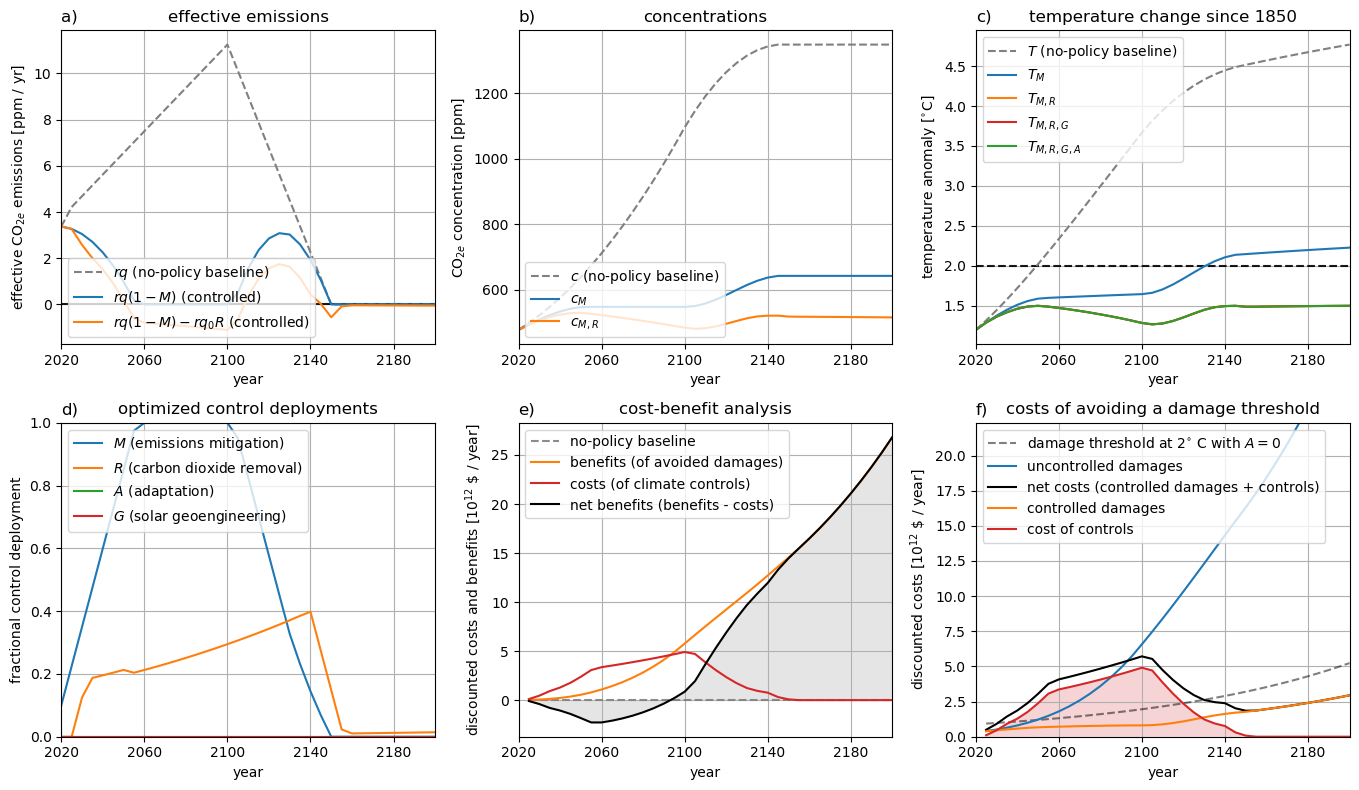

In [70]:
plot_state(m)

## Saving (and loading) MARGO simulations (or parameter configurations)

In [71]:
using ClimateMARGO.IO
export_path = tempname() * ".json"

"/var/folders/dr/t79w5jxj7xs_l_mklgcl1xt40000gn/T/jl_p9btlV.json"

In [72]:
export_parameters(export_path, params);

In [73]:
new_params = import_parameters(export_path)

ClimateModelParameters("default", Domain(5.0, 2020.0, 2020.0, 2200.0), Economics(100.0, 0.02, 0.0022222222222222222, 0.01, 8.5, 0.02, 13.0, 0.046, 4.5, 0.1, 0, 0, nothing, [7.5, 8.4375, 9.375, 10.3125, 11.25, 12.1875, 13.125, 14.0625, 15.0, 15.9375  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Physics(460.0, 1.1, 4.977297891066924, 1.13, 106.0, 0.73, 0.5))

Let's say we want to see what happens if climate feedbacks $B$ are twice as strong as they are now (which means a lower feedback parameter).

In [74]:
new_params.name = "stronger_feedbacks"
new_params.physics.B /= 2.;

In [75]:
new_m = ClimateModel(new_params, Cont)

ClimateModel("stronger_feedbacks", Domain(5.0, 2020.0, 2020.0, 2200.0), Economics(100.0, 0.02, 0.0022222222222222222, 0.01, 8.5, 0.02, 13.0, 0.046, 4.5, 0.1, 0, 0, nothing, [7.5, 8.4375, 9.375, 10.3125, 11.25, 12.1875, 13.125, 14.0625, 15.0, 15.9375  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Physics(460.0, 1.1, 4.977297891066924, 0.565, 106.0, 0.73, 0.5), Controls([0.1, 0.22500004999158896, 0.3500000999813583, 0.47500014996840134, 0.6000001999510256, 0.7250002499255481, 0.8500002998814711, 0.9750003497610793, 1.0, 1.0  …  8.083412909730559e-6, 7.885756284574008e-6, 7.69368851714835e-6, 7.5063941326073965e-6, 7.323664828300097e-6, 7.145380817918495e-6, 6.971433342709535e-6, 6.8017174975864135e-6, 6.636137927796754e-6, 6.474669604974339e-6], [0.0, 0.0, 0.12500004985859534, 0.18742960347748408, 0.1955579135384711, 0.20401821153795105, 0.21281313623504428, 0.203876118605913

The new equilibrium climate sensitivity (recall $ECS = F_{2x}/B$) is now:

In [76]:
print("ECS ≈ $(round(ECS(new_m), digits=1))°C")

ECS ≈ 6.1°C